In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error as mse
from emukit.core import ParameterSpace, ContinuousParameter

from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, \
                                                      NegativeLowerConfidenceBound, \
                                                      MaxValueEntropySearch, \
                                                      ProbabilityOfImprovement
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.preprocessing import normalize
from emukit.core.interfaces import IModel
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import skopt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import get_scorer_names
from sklearn.model_selection import train_test_split

In [2]:
def myplot(y_true_list, y_pred_list,var_list, title_str_list, color_list,region):
    fig, axes = plt.subplots(1, 2, figsize=(5.5*2, 4.5))
    fs = 18
    
    for i in range(len(axes)):
        axes[i].scatter(y_true_list[i], y_pred_list[i], alpha = 0.6, c = color_list[i])
        axes[i].plot(region[i],region[i], 'k--', alpha=0.75, zorder=0)
        axes[i].errorbar(y_true_list[i],y_pred_list[i], yerr = var_list[i], ms = 0, 
                 ls = '', capsize = 2, alpha = 0.6,
                 color = 'gray', zorder = 0)
        axes[i].set_xlabel('Ground Truth', fontsize = fs)
        axes[i].set_ylabel('Prediction', fontsize = fs)
        axes[i].set_xlim(region[i])
        axes[i].set_ylim(region[i])
        rmse = mse(y_true_list[i],y_pred_list[i],squared=False)
        title = title_str_list[i] + " (RMSE = %.3f)"%rmse
        axes[i].set_title(title, fontsize = fs)
        axes[i].grid(True, linestyle='-.')

In [3]:
# 参数空间
Tip_Height_min, Tip_Height_max, Tip_Height_step = [0.5, 50, 0.5]
Tip_Height_var = np.arange(Tip_Height_min, Tip_Height_max+0.1*Tip_Height_step,Tip_Height_step)
Tip_Height_num = len(Tip_Height_var)

Dispense_Speed_AS_min, Dispense_Speed_AS_max, Dispense_Speed_AS_step = [20,500,10]
Dispense_Speed_AS_var = np.arange(Dispense_Speed_AS_min, Dispense_Speed_AS_max+0.1*Dispense_Speed_AS_step,Dispense_Speed_AS_step)
Dispense_Speed_AS_num = len(Dispense_Speed_AS_var)

Spin_Speed_AS_min, Spin_Speed_AS_max, Spin_Speed_AS_step = [500,7000,100]
Spin_Speed_var = np.arange(Spin_Speed_AS_min,Spin_Speed_AS_max+0.1*Spin_Speed_AS_step,Spin_Speed_AS_step)
Spin_Speed_num = len(Spin_Speed_var)

Volume_AS_min, Volume_AS_max, Volume_AS_step = [50,300,10]
Volume_AS_var = np.arange(Volume_AS_min, Volume_AS_max+0.1*Volume_AS_step, Volume_AS_step)
Volume_AS_num = len(Volume_AS_var)

Timing_AS_min, Timing_AS_max, Timing_AS_step = [2,18,1]
Timing_AS_var = np.arange(Timing_AS_min, Timing_AS_max+0.1*Timing_AS_step,Timing_AS_step)
Timing_AS_num = len(Timing_AS_var)

x_label=[
    'Tip_Height',
    'Dispense_Speed_AS',
    'Spin_Speed_AS',
    'Volume_AS',
    'Timing_AS'
]

var_array = [
    Tip_Height_var,
    Dispense_Speed_AS_var,
    Spin_Speed_var,
    Volume_AS_var,
    Timing_AS_var
]


def x_normalizer(X, var_array = var_array):
    
    def max_min_scaler(x, x_max, x_min):
        return (x-x_min)/(x_max-x_min)
    x_norm = []
    for x in (X):
           x_norm.append([max_min_scaler(x[i], 
                         max(var_array[i]), 
                         min(var_array[i])) for i in range(len(x))])
            
    return np.array(x_norm)

def x_denormalizer(x_norm, var_array = var_array):
    
    def max_min_rescaler(x, x_max, x_min):
        return x*(x_max-x_min)+x_min
    x_original = []
    for x in (x_norm):
           x_original.append([max_min_rescaler(x[i], 
                              max(var_array[i]), 
                              min(var_array[i])) for i in range(len(x))])

    return np.array(x_original)


def get_closest_array(suggested_x):
    
    def get_closest_value(given_value, array_list):
        absolute_difference_function = lambda list_value : abs(list_value - given_value)
        closest_value = min(array_list, key=absolute_difference_function)
        return closest_value
    
    var_list = var_array
    modified_array = []
    for x in suggested_x:
        modified_array.append([get_closest_value(x[i], var_list[i]) for i in range(len(x))])
    return np.array(modified_array)

In [11]:
data.shape

(48, 8)

In [6]:
Test_y

array([0.21791094, 0.5677472 , 0.75839459, 0.13955233, 0.36094391,
       0.29070034, 0.29402159, 0.48327929])

In [4]:
data  = pd.read_excel('../随机森林.xlsx',usecols=[i for i in range(1,9)],sheet_name='round5').dropna()
Data = data.values

X = Data[:,:5]
Y = Data[:,6]

X_norm = x_normalizer(X)
ss_y = 0.3
Y_norm = Y/ss_y 

Train_X, Test_X, Train_y, Test_y = train_test_split(X_norm, Y_norm, test_size = 0.3,random_state=1)


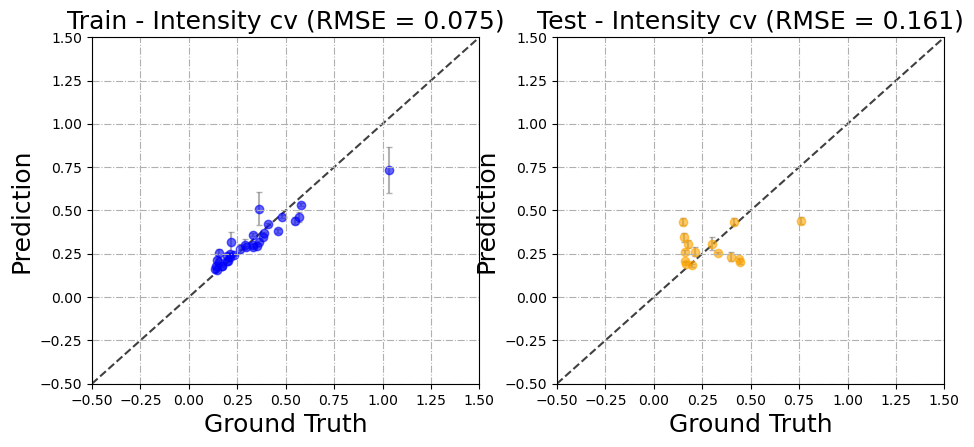

In [5]:
param  = {'n_estimators':100,
          'min_samples_leaf':1,
         'max_depth':8,
         'random_state':1,
         'oob_score':True}
rf = RFR(**param)#,min_weight_fraction_leaf=0.5)
rf.fit(Train_X,Train_y)

y_pred_train = rf.predict(Train_X)
y_pred_test = rf.predict(Test_X)

y_pred1 = np.array([rf.estimators_[i].predict(Train_X) for i in range(len(rf.estimators_)) ])
train_var = np.var(y_pred1,axis=0)
y_pred2 = np.array([rf.estimators_[i].predict(Test_X) for i in range(len(rf.estimators_)) ])
test_var = np.var(y_pred2,axis=0)

myplot([Train_y,Test_y],[y_pred_train,y_pred_test],[train_var,test_var],
       ["Train - Intensity cv","Test - Intensity cv"],
       ["blue","orange"],
      [[-0.5,1.5],[-0.5,1.5]])


In [6]:
X_normalize = x_normalizer(Data[:,:5])
Y_normalize = Data[:,6]/ss_y

param  = {'n_estimators':100,
          'min_samples_leaf':1,
         'max_depth':8,
         'random_state':1,
         'oob_score':True}
rf = RFR(**param)#,min_weight_fraction_leaf=0.5)
rf.fit(X_normalize,Y_normalize)

y_pred = rf.predict(X_normalize)

0.07006689376887594


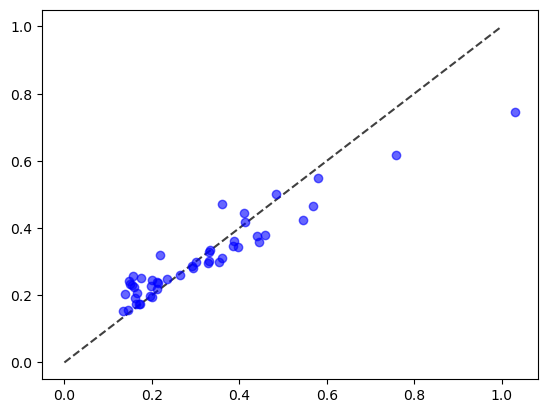

In [7]:
plt.scatter(Y_normalize,y_pred,c='b',alpha=0.6)
plt.plot([0,1],[0,1], 'k--', alpha=0.75, zorder=0)
print(mse(Y_normalize,y_pred,squared=False))

In [8]:
class RFModel(IModel):
    def __init__(self, rf_model,x,y):
        self.model = rf_model
        self.X_train_, self.y_train_ = x, y
        
    def predict(self, X):
        mean = self.model.predict(X)
        
        y_pred = np.array([self.model.estimators_[i].predict(X) for i in range(len(self.model.estimators_)) ])
        var = np.var(y_pred,axis=0)
        return mean[:, None], var[:, None]

    def set_data(self, X: np.ndarray, Y: np.ndarray) -> None:
        self.model.fit(X, Y)

    def optimize(self, verbose: bool = False) -> None:
        # There is no separate optimization routine for sklearn models
        pass

    @property
    def X(self) -> np.ndarray:
        return self.X_train_

    @property
    def Y(self) -> np.ndarray:
        return self.y_train_

emukit_model = RFModel(rf,X_normalize,Y_normalize.reshape(-1,1))

In [9]:
parameter_space = ParameterSpace([ContinuousParameter('Tip_Height', 0-1/(Tip_Height_num-1)/2, 1+1/(Tip_Height_num-1)/2),
                                  ContinuousParameter('Dispense_Speed_AS', 0-1/(Dispense_Speed_AS_num-1)/2, 1+1/(Dispense_Speed_AS_num-1)/2),
                                  ContinuousParameter('Spin_Speed', 0-1/(Spin_Speed_num-1)/2, 1+1/(Spin_Speed_num-1)/2),
                                  ContinuousParameter('Volume_AS', 0-1/(Volume_AS_num-1)/2, 1+1/(Volume_AS_num-1)/2),
                                  ContinuousParameter('Timing_AS', 0-1/(Timing_AS_num-1)/2, 1+1/(Timing_AS_num-1)/2)
                                  
                                  ])
parameter_space.parameters

[ContinuousParameter(Tip_Height, -0.005050505050505051, 1.005050505050505),
 ContinuousParameter(Dispense_Speed_AS, -0.010416666666666666, 1.0104166666666667),
 ContinuousParameter(Spin_Speed, -0.007692307692307693, 1.0076923076923077),
 ContinuousParameter(Volume_AS, -0.02, 1.02),
 ContinuousParameter(Timing_AS, -0.03125, 1.03125)]

In [10]:
np.random.seed(1000)

beta = [0.1,1,10]
recommend_point = []
num = 3
for i in range(num):
    bs = 1

    objective_model = emukit_model

    acquisition = NegativeLowerConfidenceBound(objective_model, beta = beta[i])#ExpectedImprovement(objective_model, jitter=beta[i])#NegativeLowerConfidenceBound(objective_model, beta = beta[i])#ExpectedImprovement(objective_model, jitter=.1)#NegativeLowerConfidenceBound(objective_model, beta = 1)

    bayesopt= BayesianOptimizationLoop(model=objective_model, 
                                       space=parameter_space, 
                                       acquisition=acquisition,
                                       batch_size = bs)


    X_new = bayesopt.candidate_point_calculator.compute_next_points(bayesopt.loop_state)

    recommend_point.append(get_closest_array(x_denormalizer(X_new,var_array)))
    
recommend_point_pd = pd.DataFrame(np.array(recommend_point).reshape(-1,5), columns = x_label)

rp = x_normalizer(np.array(recommend_point).reshape(num,5))
u = ss_y*(rf.predict(rp).reshape(-1,1)) #均值
sigma = ss_y*np.sqrt(emukit_model.predict(rp)[1]) #标准差
pred = pd.DataFrame(np.append(u,sigma,axis=1),columns=['pred_mean','pred_sigma'])
final = pd.concat([recommend_point_pd, pred], axis=1)
final

1000000
Init point :  [0.64628543 0.36218053 0.52477848 0.33821955 0.99508602]
(array([0.64628543, 0.36218053, 0.52477848, 0.33821955, 0.99508602]), 0.14933224996435485, {'grad': array([0., 0., 0., 0., 0.]), 'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL', 'funcalls': 6, 'nit': 0, 'warnflag': 0})
opt point :  (array([[0.64628543, 0.36218053, 0.52477848, 0.33821955, 0.99508602]]), array([[0.14933225]]))
acq_max =  [[-0.14933225]]
1000000
Init point :  [0.68591719 0.416109   0.48460651 0.21918003 0.93902191]
(array([0.68591719, 0.416109  , 0.48460651, 0.21918003, 0.93902191]), 0.05569325202917361, {'grad': array([0., 0., 0., 0., 0.]), 'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL', 'funcalls': 6, 'nit': 0, 'warnflag': 0})
opt point :  (array([[0.68591719, 0.416109  , 0.48460651, 0.21918003, 0.93902191]]), array([[0.05569325]]))
acq_max =  [[-0.05569325]]
1000000
Init point :  [0.17595007 0.58052615 0.21229428 0.20586168 0.08317474]
(array([0.17595007, 0.58052615, 0

,Tip_Height,Dispense_Speed_AS,Spin_Speed_AS,Volume_AS,Timing_AS,pred_mean,pred_sigma
0,32.5,190.0,3900.0,130.0,18.0,0.046137,0.011311
1,34.5,220.0,3600.0,100.0,17.0,0.071538,0.053808
2,9.0,300.0,1900.0,100.0,3.0,0.143651,0.078583


In [12]:
final.to_excel('Intensity cv2.xlsx')